In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    RocCurveDisplay
)
import shap
import os

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [14]:
X_test = np.load("./data/X_test_scaled.npy")
y_test = np.load("./data/y_test.npy")

input_dim = X_test.shape[1]
model = MLP(input_dim)
model.load_state_dict(torch.load("./models/mlp_model.pth"))
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=48, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [15]:
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred_logits = model(X_test_tensor)
    y_pred_probs = torch.sigmoid(y_pred_logits).numpy()
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)

results_df = pd.DataFrame({
    "true_label": y_test,
    "pred_label": y_pred_labels,
    "pred_prob": y_pred_probs
})

In [16]:
top_fraudes = results_df.sort_values("pred_prob", ascending=False).head(10)
top_fraudes

,true_label,pred_label,pred_prob
11684,0,1,0.794175
157107,1,1,0.793098
90085,0,1,0.775901
89235,1,1,0.773655
216068,1,1,0.769382
42505,1,1,0.758115
104850,0,1,0.755297
66854,1,1,0.755177
224461,0,1,0.754331
85616,1,1,0.751624


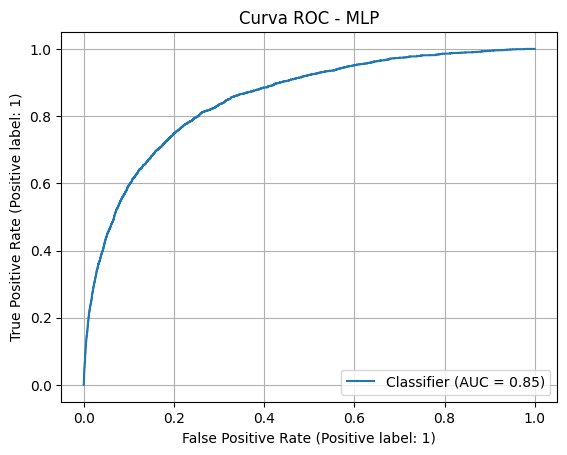

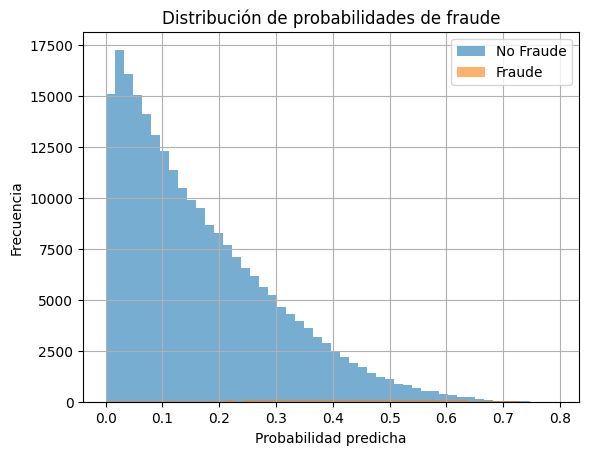

In [17]:
RocCurveDisplay.from_predictions(y_test, y_pred_probs)
plt.title("Curva ROC - MLP")
plt.grid(True)
plt.show()

plt.hist(y_pred_probs[y_test == 0], bins=50, alpha=0.6, label="No Fraude")
plt.hist(y_pred_probs[y_test == 1], bins=50, alpha=0.6, label="Fraude")
plt.title("Distribución de probabilidades de fraude")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
explainer = shap.KernelExplainer(
    model=lambda x: torch.sigmoid(model(torch.tensor(x, dtype=torch.float32))).detach().numpy(),
    data=X_test[:100]
)

shap_values = explainer.shap_values(X_test[:100], nsamples=100)

100%|██████████| 100/100 [00:00<00:00, 104.78it/s]


In [19]:
df = pd.read_csv("./data/preprocessed_data.csv")
df_test = df[df["month"] >= 6].copy()

X_test_named = df_test.drop(columns=["fraud_bool", "month", "x1", "x2"], errors="ignore")
X_test_named = pd.get_dummies(X_test_named, drop_first=True)
X_test_np = np.load("./data/X_test_scaled.npy")
X_test_named = X_test_named.iloc[:, :X_test_np.shape[1]]
X_shap = pd.DataFrame(X_test_np[:100], columns=X_test_named.columns[:X_test_np.shape[1]])



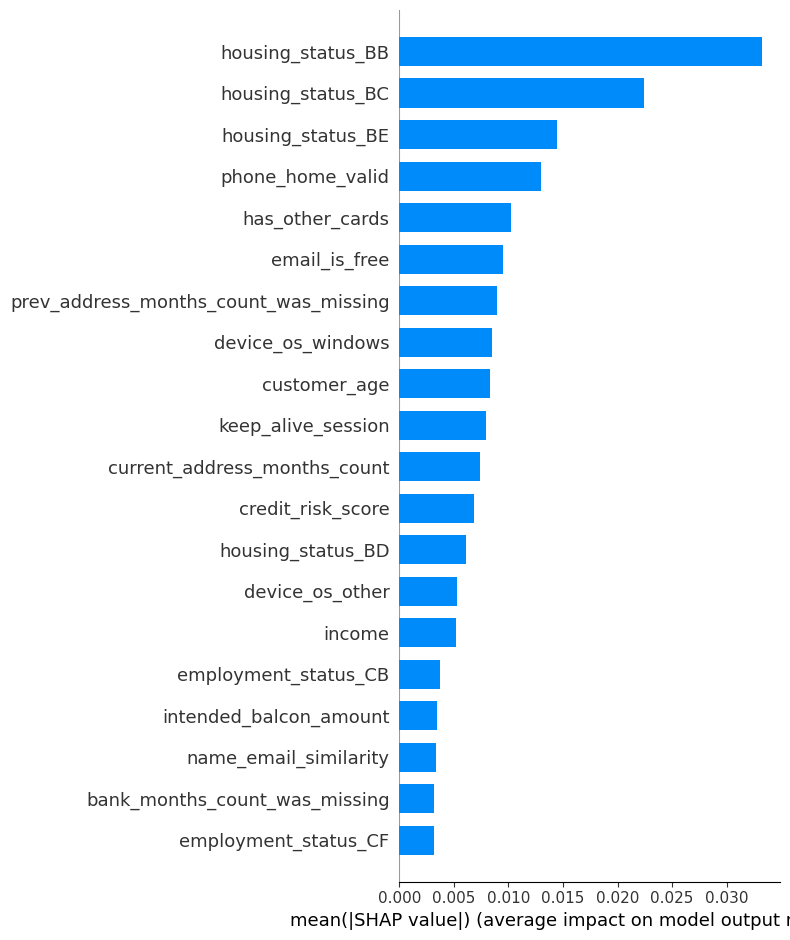

In [20]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

In [21]:
top_fraudes_local = results_df.iloc[:100].sort_values("pred_prob", ascending=False).head(10)
index = top_fraudes_local.index[0]

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[index],
    features=X_shap.iloc[index],
    feature_names=X_shap.columns.tolist()
)

In [22]:
print(classification_report(y_test, y_pred_labels, digits=4))
print("AUC final:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_labels))

# With smote is better in [F1-Score 1] and [Recall 1].
# Without smote is less precise but ignoring the actual cases

              precision    recall  f1-score   support

           0     0.9921    0.9769    0.9845    239020
           1     0.1269    0.3020    0.1787      2652

    accuracy                         0.9695    241672
   macro avg     0.5595    0.6395    0.5816    241672
weighted avg     0.9826    0.9695    0.9756    241672

AUC final: 0.8514691226606179
Confusion Matrix:
 [[233509   5511]
 [  1851    801]]
